In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
from math import sin, cos, radians
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import cufflinks as cf
cf.set_config_file(offline=True, sharing=False, theme='ggplot');
from statsmodels.graphics.tsaplots import plot_pacf
sns.set()

In [56]:
# If using google colab
#from google.colab import drive
#drive.mount('/content/drive')
#path = '/content/drive/MyDrive/PredictingTide/Data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Get Data

In [57]:
# If running local
df_data_1996 = pd.read_csv(f'../Data/BHPtrainingLongProcessed.zip', index_col = 'Date Time', parse_dates=True)
df_data_2016 = pd.read_csv(f'../Data/BHPtraining.csv', index_col = 'Date Time', parse_dates = True)
df_data_2020 = pd.read_csv(f'../Data/BHPtest.csv', index_col = 'Date Time', parse_dates = True)

In [58]:
# If running on google colab
#df_data_1996 = pd.read_csv(f'{path}/BHPtrainingLongProcessed.zip', index_col = 'Date Time', parse_dates=True)
#df_data_2016 = pd.read_csv(f'{path}/BHPtraining.csv', index_col = 'Date Time', parse_dates = True)
#df_data_2020 = pd.read_csv(f'{path}/BHPtest.csv', index_col = 'Date Time', parse_dates = True)

In [59]:
df_data_2020.head()

,Air Temperature,Water Level,Water Level Sigma,Wind Speed,Wind Direction,Wind Gust
Date Time,,,,,,
2020-01-01 00:00:00,59.0,1.499,0.197,12.44,30.0,15.94
2020-01-01 00:06:00,59.0,1.486,0.180,13.41,33.0,16.33
2020-01-01 00:12:00,59.2,1.490,0.194,12.83,37.0,14.97
2020-01-01 00:18:00,59.2,1.578,0.223,12.44,34.0,15.16
2020-01-01 00:24:00,59.0,1.522,0.194,13.22,28.0,16.13


In [60]:
'''df_raw = pd.read_csv(f'../Data/resampled_data.csv', index_col='DATE', parse_dates=True)'''

"df_raw = pd.read_csv(f'../Data/resampled_data.csv', index_col='DATE', parse_dates=True)"

In [61]:
def raw_dataset():
    df_raw = pd.concat([df_data_1996, df_data_2016, df_data_2020])
    return df_raw

# Process Data

In [62]:
def preprocess(dataframe):
    # Drop minute data
    df = dataframe[dataframe.index.minute == 0].copy()
    df = df.drop(['Water Level', 'Water Level Sigma'], axis=1)
    # Calculate across and along shore winds, offset of 30 degrees
    df['uWind'] = df['Wind Speed'].multiply(np.cos(np.radians(df['Wind Direction']-30)))
    df['vWind'] = df['Wind Speed'].multiply(np.sin(np.radians(df['Wind Direction']-30)))
    # Create Season feature
    df['season'] = np.where(df.index.month.isin([12, 1, 2]), 'winter',
                                np.where(df.index.month.isin([3, 4, 5]), 'spring',
                                         np.where(df.index.month.isin([6, 7, 8]), 'summer', 'fall')))
    # Create dummy variables for Season, to be used in regression model
    df = pd.get_dummies(df, columns=['season'], drop_first=True)
    #Remove significant outliers in Air Temperature
    df = df[np.abs(df['Air Temperature'] - df['Air Temperature'].mean()) <= (3 * df['Air Temperature'].std())]
    # Interpolate Missing Data: 3 hour limit for winds, 12 hour limit for Water Level, Surge, and Water Level Sigma
    df[['uWind', 'vWind', 'Wind Speed', 'Wind Gust', 'Air Temperature']] = df[['uWind', 'vWind', 'Wind Speed', 'Wind Gust', 'Air Temperature']].interpolate(method='linear', limit=12)
    # Drop remaining missing values

    return df.loc['2005':]

In [63]:
df_raw = raw_dataset()
df_clean = preprocess(df_raw)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 118611 entries, 2005-01-01 00:00:00 to 2020-10-21 01:00:00
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Air Temperature  118611 non-null  float64
 1   Wind Speed       118611 non-null  float64
 2   Wind Direction   118225 non-null  float64
 3   Wind Gust        118611 non-null  float64
 4   uWind            118611 non-null  float64
 5   vWind            118611 non-null  float64
 6   season_spring    118611 non-null  bool   
 7   season_summer    118611 non-null  bool   
 8   season_winter    118611 non-null  bool   
dtypes: bool(3), float64(6)
memory usage: 6.7 MB


In [64]:
df_clean.head()

,Air Temperature,Wind Speed,Wind Direction,Wind Gust,uWind,vWind,season_spring,season_summer,season_winter
Date Time,,,,,,,,,
2005-01-01 00:00:00,62.2,10.30,87.0,11.27,5.609782,8.638307,False,False,True
2005-01-01 01:00:00,62.6,11.66,91.0,12.63,5.652880,10.198066,False,False,True
2005-01-01 02:00:00,62.4,11.66,95.0,13.02,4.927729,10.567549,False,False,True
2005-01-01 03:00:00,63.5,11.27,96.0,12.25,4.583922,10.295657,False,False,True
2005-01-01 04:00:00,63.0,10.50,92.0,11.08,4.929451,9.270950,False,False,True


In [65]:
df_test = df_clean.copy()
df_test['Lag_24'] = df_test['Air Temperature'].shift(24)
df_test = df_test[['Air Temperature', 'Lag_24']].dropna()
corr = df_test['Air Temperature'].corr(df_test['Lag_24'])
corr = f'correlation: {corr}'

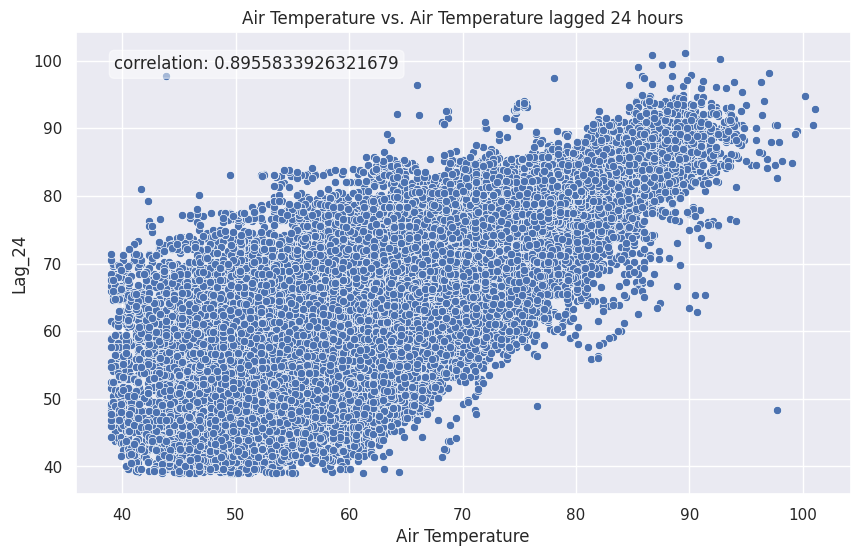

In [66]:
plt.figure(figsize=(10,6), dpi=100)
plt.title('Air Temperature vs. Air Temperature lagged 24 hours')
plt.text(0.05, 0.95, corr, transform=plt.gca().transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
sns.scatterplot(data=df_test, x='Air Temperature', y='Lag_24');

# Explore Data

## Autocorrelation

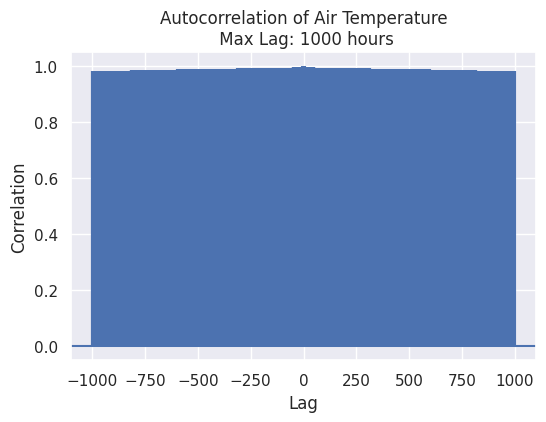

In [67]:
fig = plt.figure(figsize=(6,4))
plt.acorr(df_clean['Air Temperature'], maxlags=1000)
plt.title('Autocorrelation of Air Temperature\n Max Lag: 1000 hours')
plt.xlabel('Lag')
plt.ylabel('Correlation');


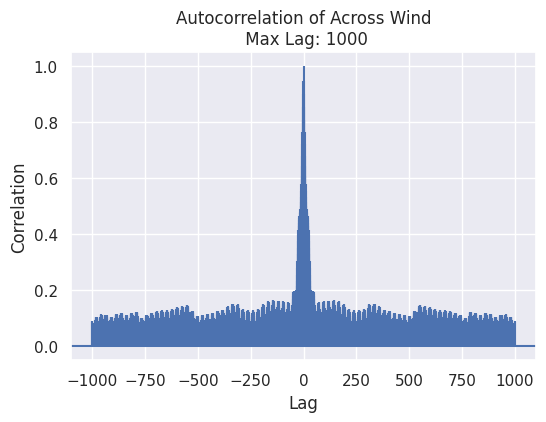

In [68]:
fig = plt.figure(figsize=(6,4))
plt.acorr(df_clean['uWind'], maxlags=1000)
plt.title('Autocorrelation of Across Wind\n Max Lag: 1000')
plt.xlabel('Lag')
plt.ylabel('Correlation');

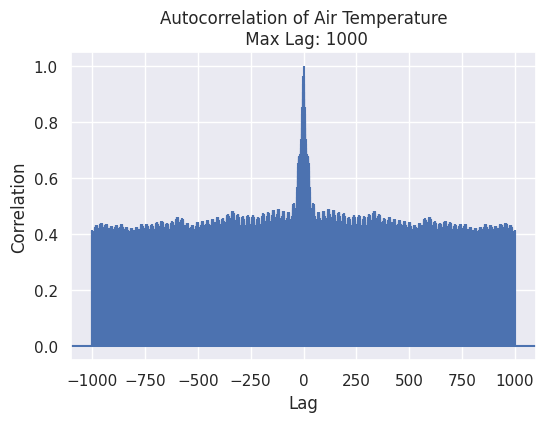

In [69]:
fig = plt.figure(figsize=(6,4))
plt.acorr(df_clean['vWind'], maxlags=1000)
plt.title('Autocorrelation of Air Temperature\n Max Lag: 1000')
plt.xlabel('Lag')
plt.ylabel('Correlation');

## Correlation Analysis

In [70]:
df_clean.corr()

,Air Temperature,Wind Speed,Wind Direction,Wind Gust,uWind,vWind,season_spring,season_summer,season_winter
Air Temperature,1.000000,0.059087,-0.179682,0.025537,-0.372703,0.551839,-0.060662,0.545453,-0.679815
Wind Speed,0.059087,1.000000,-0.037607,0.983216,0.041019,0.263912,0.112976,0.009308,-0.098653
Wind Direction,-0.179682,-0.037607,1.000000,0.012443,-0.230294,-0.381291,-0.058192,-0.017005,0.063477
Wind Gust,0.025537,0.983216,0.012443,1.000000,0.071287,0.183626,0.114519,-0.010362,-0.091083
uWind,-0.372703,0.041019,-0.230294,0.071287,1.000000,-0.524225,-0.010845,-0.266191,0.181218
vWind,0.551839,0.263912,-0.381291,0.183626,-0.524225,1.000000,0.144943,0.249535,-0.309800
season_spring,-0.060662,0.112976,-0.058192,0.114519,-0.010845,0.144943,1.000000,-0.330741,-0.331062
season_summer,0.545453,0.009308,-0.017005,-0.010362,-0.266191,0.249535,-0.330741,1.000000,-0.331922
season_winter,-0.679815,-0.098653,0.063477,-0.091083,0.181218,-0.309800,-0.331062,-0.331922,1.000000


## Seasonal Analysis

## Distribution Plots

<Axes: title={'center': 'Daily Air Temperature for years 2005-2020'}, xlabel='Date Time', ylabel='Air Temperature'>

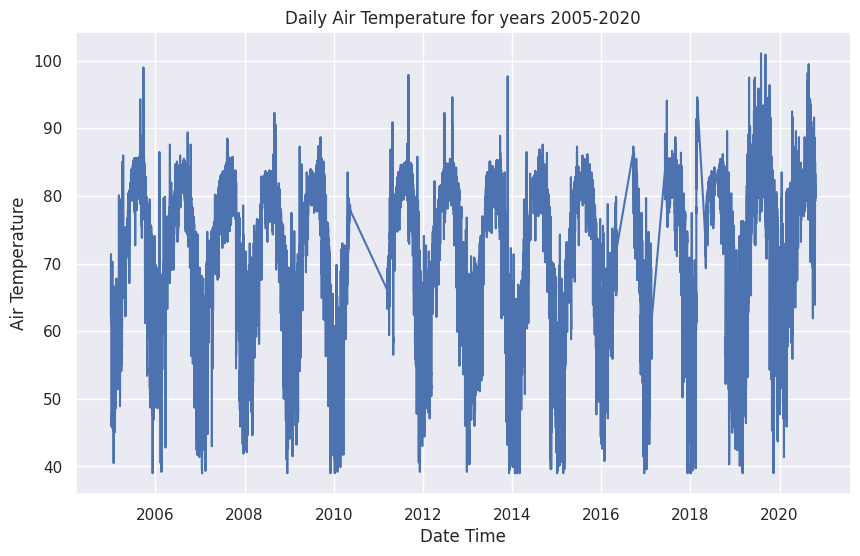

In [71]:
fig=plt.figure(figsize=(10,6), dpi=100)
plt.title('Daily Air Temperature for years 2005-2020')
sns.lineplot(data=df_clean, x=df_clean.index, y=df_clean['Air Temperature'])

<Axes: title={'center': 'Average Temperature per Month'}, xlabel='Date Time', ylabel='Air Temperature'>

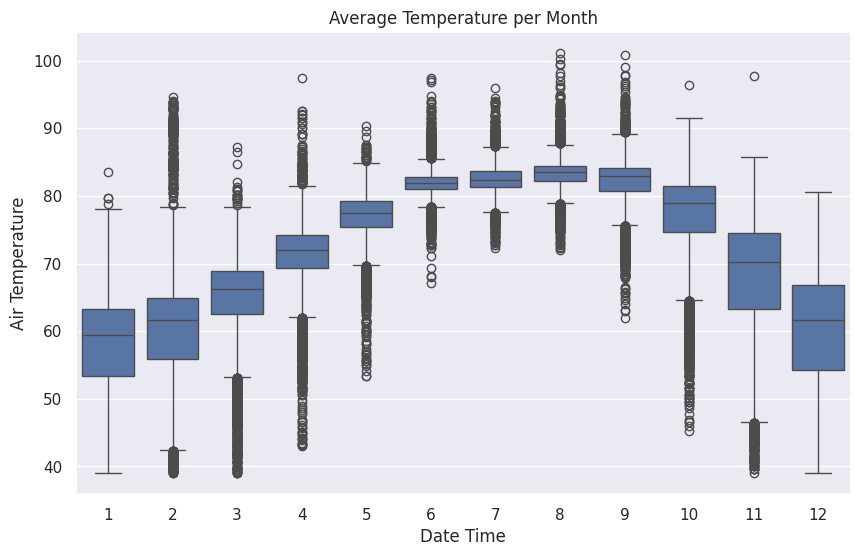

In [72]:
plt.figure(figsize=(10,6), dpi=100)
plt.title("Average Temperature per Month")
sns.boxplot(data=df_clean, x=df_clean.index.month, y=df_clean['Air Temperature'])

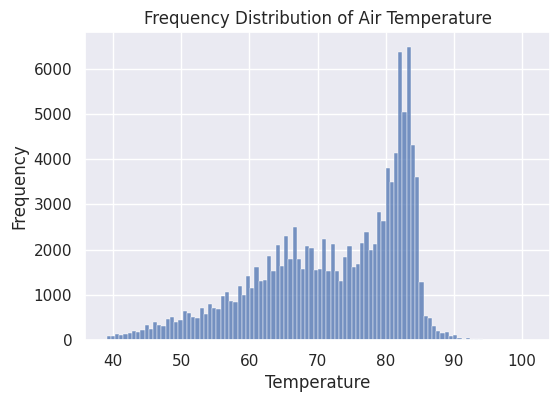

In [73]:
fig=plt.figure(figsize=(6,4))
sns.histplot(df_clean['Air Temperature'], bins=100);
plt.title("Frequency Distribution of Air Temperature")
plt.ylabel("Frequency")
plt.xlabel("Temperature");

In [74]:
df_test = df_clean[['Air Temperature', 'uWind', 'vWind']].copy()

In [75]:
df_test['Lag_uWind'] = df_test['uWind'].shift(24)
df_test['Lag_vWind'] = df_test['vWind'].shift(24)
df_test = df_test.dropna()

In [76]:
df_test

,Air Temperature,uWind,vWind,Lag_uWind,Lag_vWind
Date Time,,,,,
2005-01-02 00:00:00,65.1,4.847431,10.395350,5.609782,8.638307
2005-01-02 01:00:00,65.5,2.616661,9.765510,5.652880,10.198066
2005-01-02 02:00:00,65.5,5.707544,17.566014,4.927729,10.567549
2005-01-02 03:00:00,71.4,-3.988210,11.582603,4.583922,10.295657
2005-01-02 04:00:00,66.2,-2.060405,9.693443,4.929451,9.270950
...,...,...,...,...,...
2020-10-20 21:00:00,81.7,9.471817,7.137526,3.269059,11.400564
2020-10-20 22:00:00,80.2,8.812812,8.218080,4.319714,11.868318
2020-10-20 23:00:00,79.7,9.044452,9.365804,4.174751,15.580384


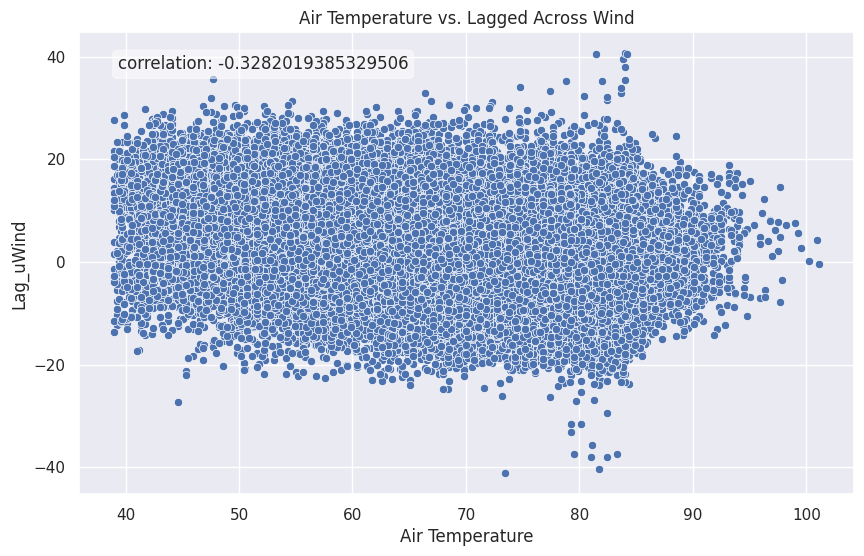

In [77]:
corr = df_test['Air Temperature'].corr(df_test['Lag_uWind'])
corr = f'correlation: {corr}'
plt.figure(figsize=(10,6), dpi=100)
plt.title('Air Temperature vs. Lagged Across Wind')
plt.text(0.05, 0.95, corr, transform=plt.gca().transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
sns.scatterplot(data=df_test, x='Air Temperature', y='Lag_uWind');

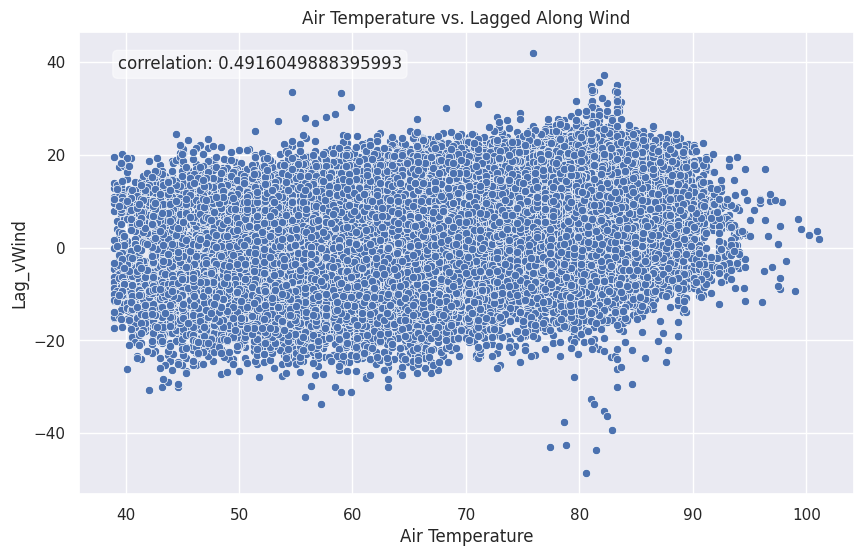

In [78]:
corr = df_test['Air Temperature'].corr(df_test['Lag_vWind'])
corr = f'correlation: {corr}'
plt.figure(figsize=(10,6), dpi=100)
plt.title('Air Temperature vs. Lagged Along Wind')
plt.text(0.05, 0.95, corr, transform=plt.gca().transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
sns.scatterplot(data=df_test, x='Air Temperature', y='Lag_vWind');

## Summary Statistics

In [79]:
df_clean['Air Temperature'].describe()

count    118611.000000
mean         72.262767
std          10.813227
min          39.000000
25%          64.800000
50%          74.700000
75%          81.700000
max         101.100000
Name: Air Temperature, dtype: float64

# Prepare Data

## Prepare Labels/Features

In [80]:
def data_sample(df, features, leadtime_hours=24):
  data = []
  labels = []

  for index, row in df.iterrows():

    if index.hour == 0 or index.hour == 12:
        # Start and End time for 24 hours prior to observation
        end_datetime = index - pd.Timedelta(hours = 24)
        start_datetime = end_datetime - pd.Timedelta(hours = leadtime_hours)

        # Slice the DataFrame into 24 hour windows
        window = df.loc[start_datetime:end_datetime]
        # If we do not have 24 hours of continuous data, throw out interval
        if window.shape != (leadtime_hours + 1, df.shape[1]):
            continue

        # Extract the ith observation for our label value
        label = None
        try:
            label = df.loc[index]['Air Temperature']
        except KeyError:
            continue

        # Transform each feature into a array containing 24 hours worth of values of that feature
        input_vector = []
        for feature in features:
            input_vector = input_vector + window[feature].tolist()

        data.append(input_vector)
        labels.append(label)

  return data, labels

## Evaluation Functions

In [81]:
def central_frequency(predictions, labels):
    temp = 0

    for i in range(0, len(predictions)):
        if abs(predictions[i] - labels[i]) <= 5:
            temp = temp + 1
    return temp / len(predictions)

In [82]:
def evaluate(predictions, labels, predictions_best):
    mse = mean_squared_error(predictions, labels)
    rmse = np.sqrt(mse)
    r2 = r2_score(predictions, labels)
    cf = central_frequency(predictions, labels)

    print("\nCentral Frequency:", cf)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", rmse)
    print("R-squared:", r2)

    mse_best = mean_squared_error(predictions_best, labels)
    r2_best = r2_score(predictions_best, labels)
    cf_best = central_frequency(predictions_best, labels)

    print('-------------------')
    print('Difference from Current Best Model')
    print('-------------------')
    print('Central Frequency Difference: {:.6f}'.format(cf_best-cf))
    print('Mean Square Error Difference:{:.6f}'.format(mse_best-mse))
    print('R-squared Difference:{:.6f}'.format(r2_best-r2))
    print('')

In [83]:
def evaluate_final(predictions, labels):
    mse = mean_squared_error(predictions, labels)
    rmse = np.sqrt(mse)
    r2 = r2_score(predictions, labels)
    cf = central_frequency(predictions, labels)

    print("\nCentral Frequency:", cf)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", rmse)
    print("R-squared:", r2)

In [84]:
def model_plot(predictions, labels, title):
    plt.figure(figsize=(25,10))
    plt.plot(labels, label='Targets')
    plt.plot(predictions, label='Predictions')
    plt.title(f'Predictions vs Targets\n{title}', size=22)
    plt.xlabel('Observation (24hr Lag)', size=22)
    plt.ylabel('Temperature', size=22)
    plt.legend()
    plt.show()

## Train/Validate/Test Split

In [85]:
def data_split(dataframe):
    train = dataframe[((dataframe.index.year >= 2005) & (dataframe.index.year <= 2018))]
    validate = dataframe[dataframe.index.year == 2019]
    test = dataframe[dataframe.index.year == 2020]

    return train, validate, test

In [86]:
df_train, df_validate, df_test = data_split(df_clean)

# Linear Regression

In [87]:
training_data, training_labels = data_sample(df_train, ['Air Temperature'])
validation_data, validation_labels = data_sample(df_validate, ['Air Temperature'])
testing_data, testing_labels = data_sample(df_test, ['Air Temperature'])
model = LinearRegression()
model.fit(training_data, training_labels)
predictions = model.predict(training_data)
evaluate_final(predictions, training_labels)
models = {'LR/Temp': [model.predict(training_data), model.predict(validation_data), model.predict(testing_data)]}


Central Frequency: 0.8468356398693827
Mean Squared Error: 19.91754096603861
Root Mean Squared Error: 4.462907232515438
R-squared: 0.7790336778986042


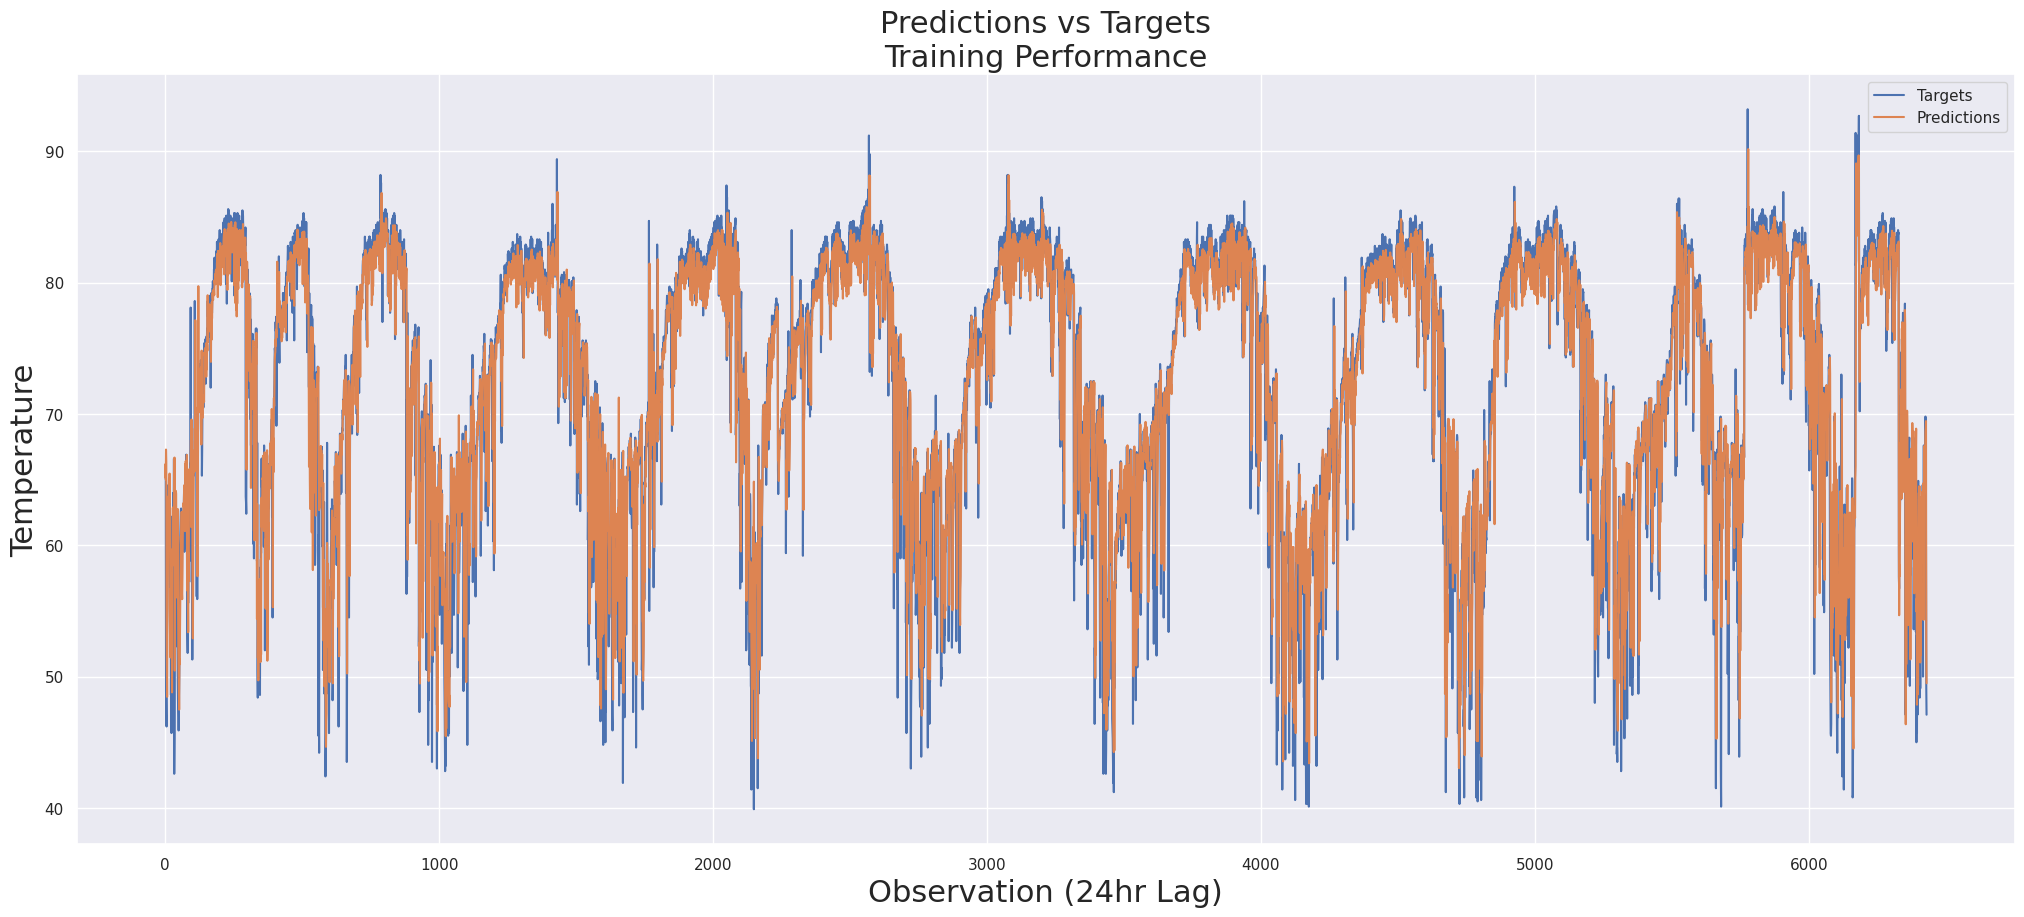

In [88]:
model_plot(predictions, training_labels, 'Training Performance')


Central Frequency: 0.801056338028169
Mean Squared Error: 30.10783974560964
Root Mean Squared Error: 5.48706112100181
R-squared: 0.7476786145240626


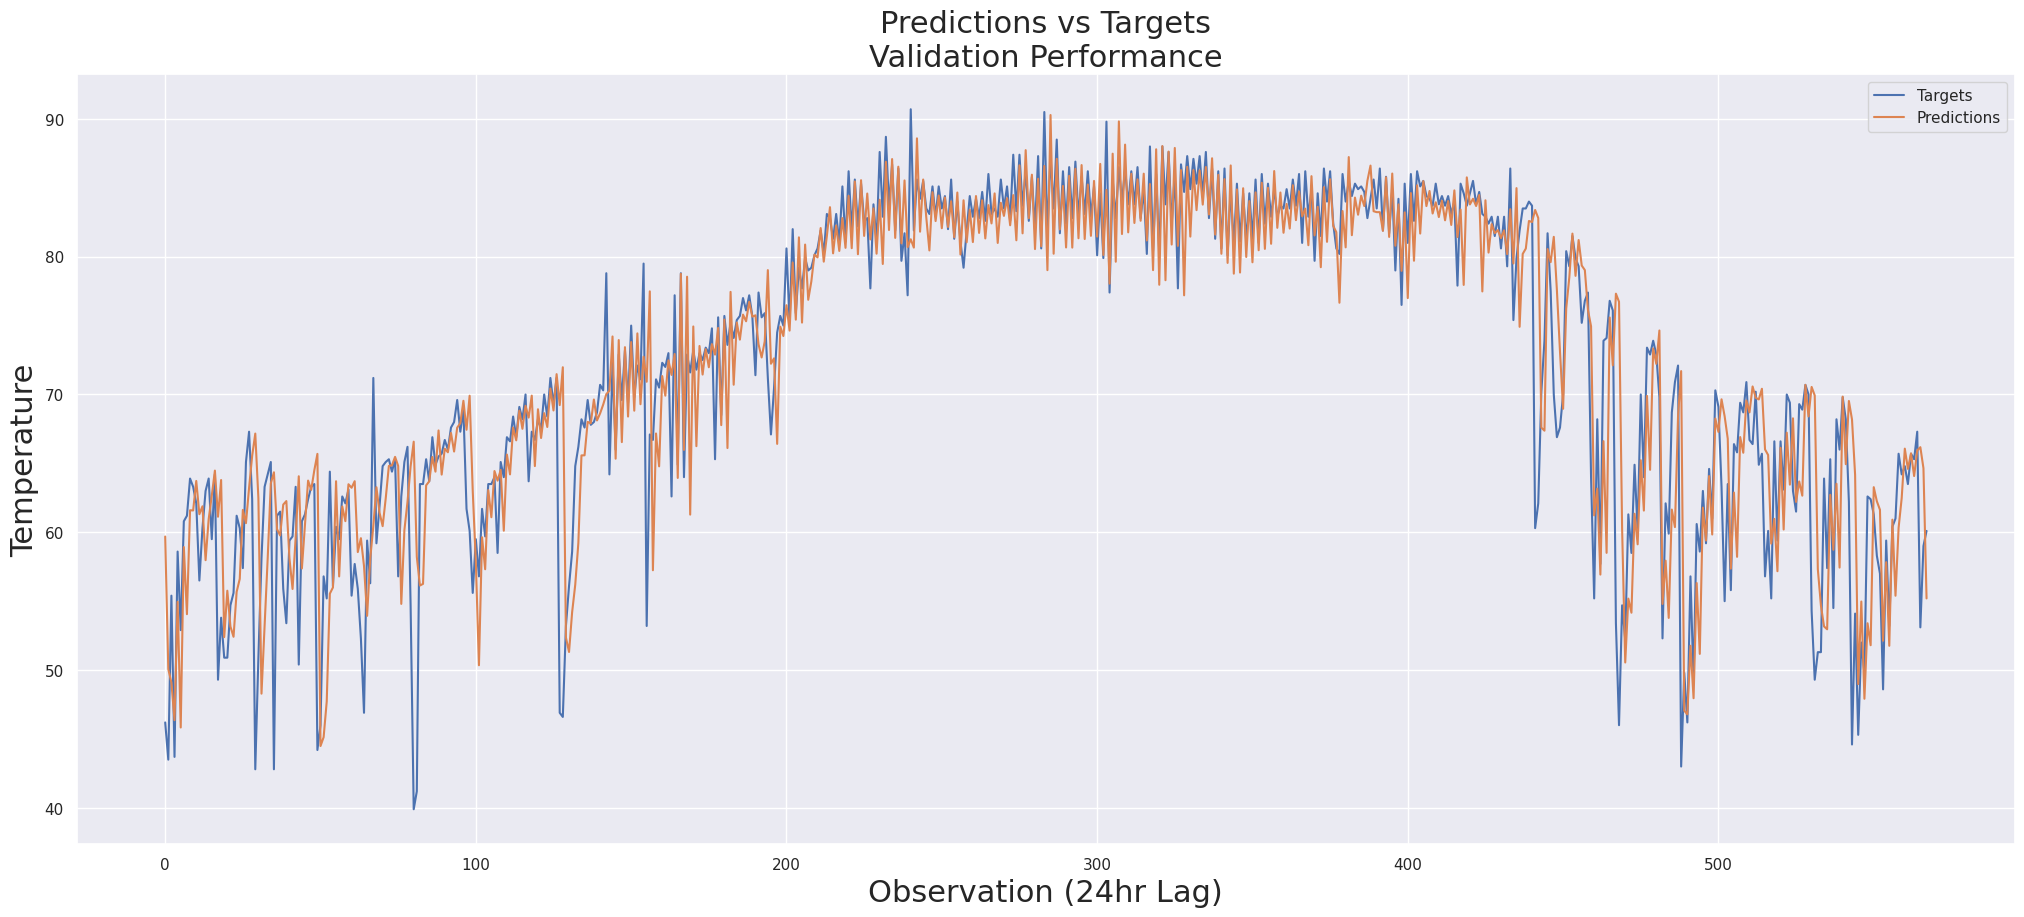

In [89]:
predictions = model.predict(validation_data)
evaluate_final(predictions, validation_labels)
model_plot(predictions, validation_labels, 'Validation Performance')

In [90]:
training_data, training_labels = data_sample(df_train, ['Air Temperature',  'Wind Speed', 'Wind Gust', 'uWind', 'vWind'])
validation_data, validation_labels = data_sample(df_validate, ['Air Temperature', 'Wind Speed', 'Wind Gust', 'uWind', 'vWind'])
testing_data, testing_labels = data_sample(df_test, ['Air Temperature', 'Wind Speed', 'Wind Gust', 'uWind', 'vWind'])
model = LinearRegression()
model.fit(training_data, training_labels)
predictions = model.predict(training_data)
evaluate_final(predictions, training_labels)
models['LR/Wind'] = [model.predict(training_data), model.predict(validation_data), model.predict(testing_data)]


Central Frequency: 0.8625408179132328
Mean Squared Error: 16.947086367899814
Root Mean Squared Error: 4.116683904297221
R-squared: 0.8179862218021416



Central Frequency: 0.8080985915492958
Mean Squared Error: 25.72054953927975
Root Mean Squared Error: 5.0715431122371175
R-squared: 0.7945996201814842


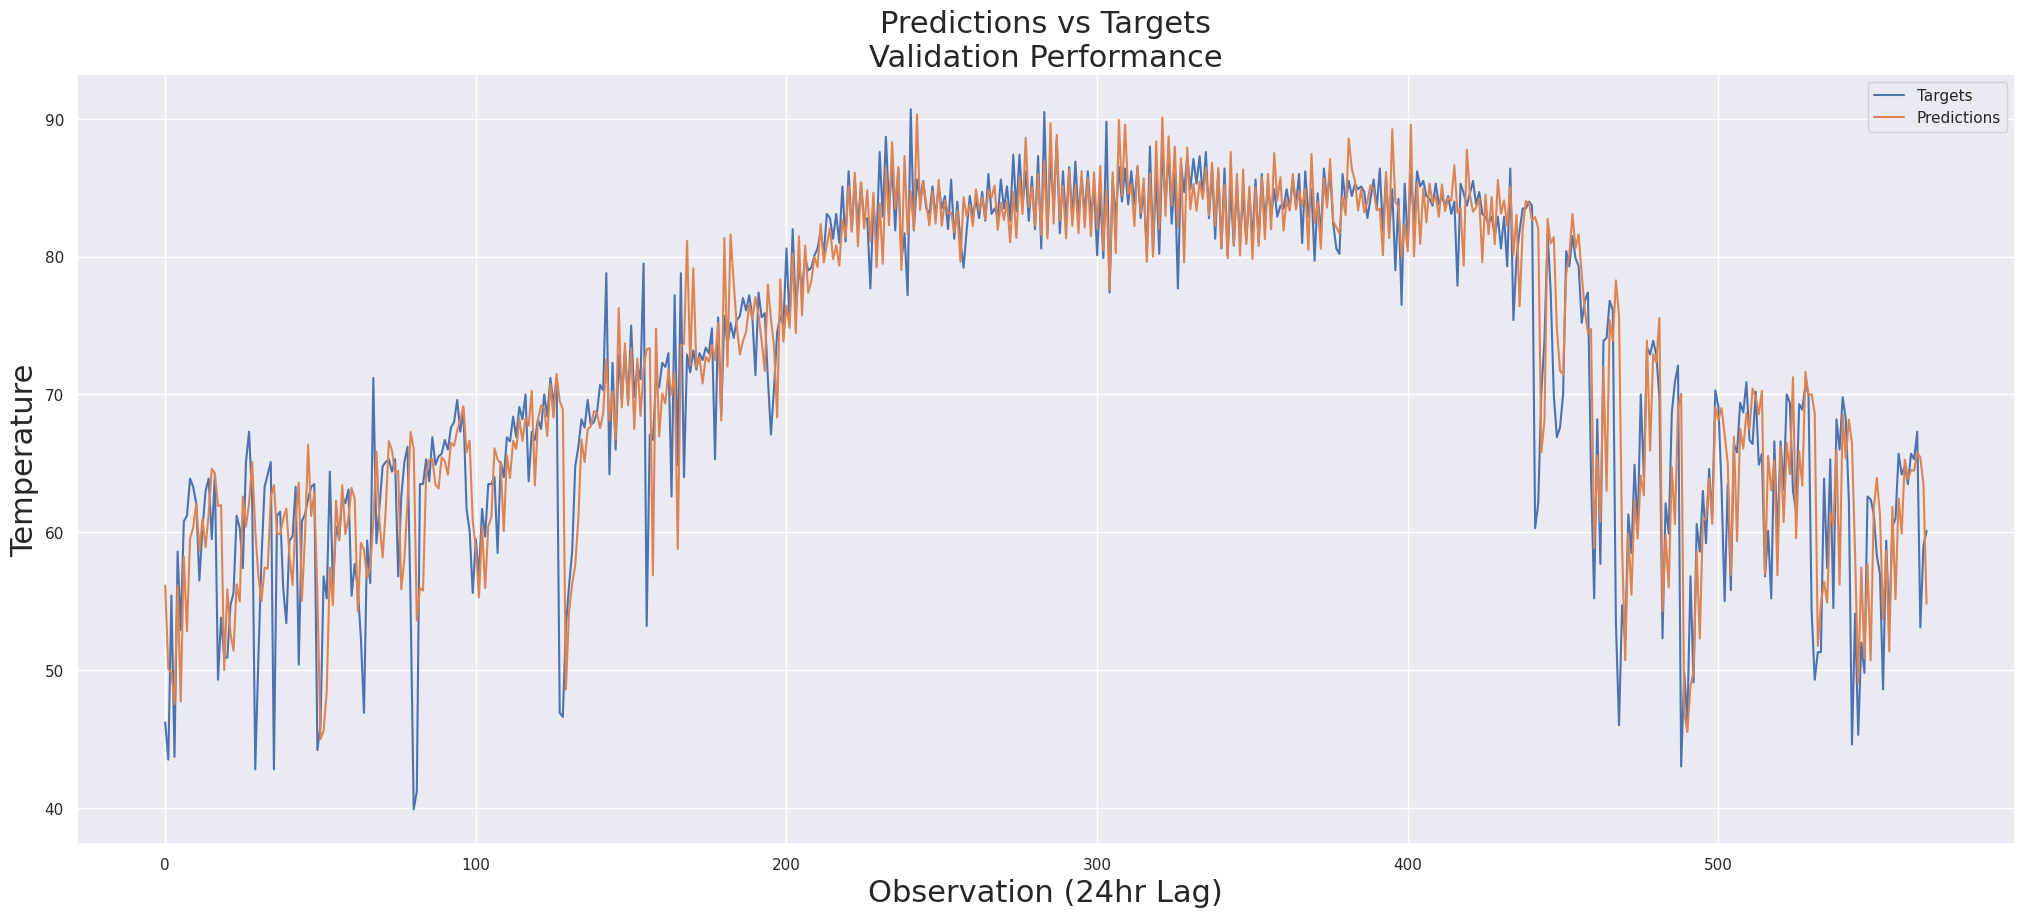

In [91]:
predictions = model.predict(validation_data)
evaluate_final(predictions, validation_labels)
model_plot(predictions, validation_labels, "Validation Performance")

In [92]:
training_data, training_labels = data_sample(df_train, ['Air Temperature',  'vWind', 'uWind', 'Wind Speed', 'Wind Gust', 'season_summer', 'season_spring', 'season_winter'])
validation_data, validation_labels = data_sample(df_validate, ['Air Temperature',  'vWind',  'uWind', 'Wind Speed', 'Wind Gust', 'season_summer', 'season_spring', 'season_winter'])
testing_data, testing_labels = data_sample(df_test, ['Air Temperature',  'vWind', 'uWind', 'Wind Speed', 'Wind Gust', 'season_summer', 'season_spring', 'season_winter'])
model = LinearRegression()
model.fit(training_data, training_labels)
predictions = model.predict(training_data)
evaluate_final(predictions, training_labels)
models['LR/All'] = [model.predict(training_data), model.predict(validation_data), model.predict(testing_data)]


Central Frequency: 0.8651842637225937
Mean Squared Error: 16.264752491644284
Root Mean Squared Error: 4.032958280424468
R-squared: 0.8265854136461477



Central Frequency: 0.829225352112676
Mean Squared Error: 24.353737518161118
Root Mean Squared Error: 4.934950609495613
R-squared: 0.8007520644701746


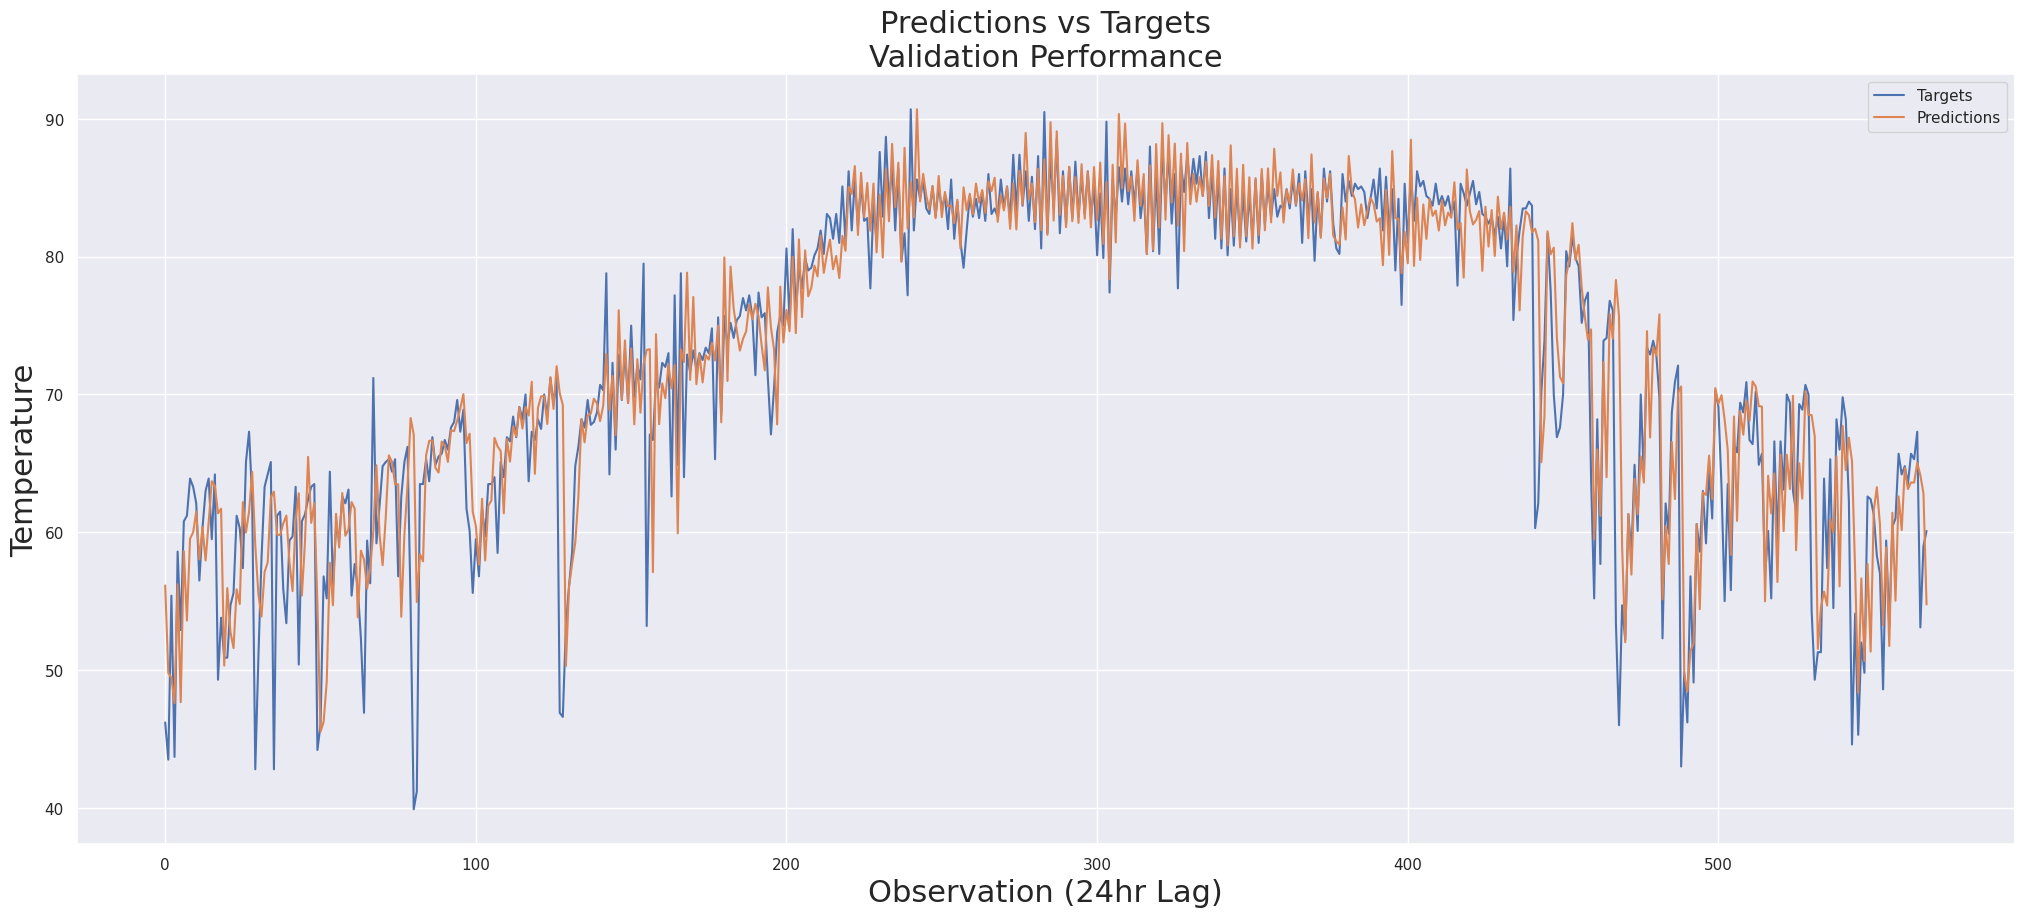

In [93]:
predictions = model.predict(validation_data)
evaluate_final(predictions, validation_labels)
model_plot(predictions, validation_labels, 'Validation Performance')

<b>Compare Model Performance</b>

In [94]:
def rmse(y, yhat):
    return np.sqrt(np.mean((y - yhat)**2))

In [95]:
def compare_rmse(models):
    training_rmse = [rmse(training_labels, models[key][0]) for key in models.keys()]
    validation_rmse = [rmse(validation_labels, models[key][1]) for key in models.keys()]
    testing_rmse = [rmse(testing_labels, models[key][2]) for key in models.keys()]

    names = list(models.keys())
    fig = go.Figure([
        go.Bar(x = names, y = training_rmse, name="Training RMSE"),
        go.Bar(x = names, y = validation_rmse, name="Validation RMSE"),
        go.Bar(x = names, y = testing_rmse, name="Test RMSE", opacity=.3)])
    return fig

In [96]:
def compare_cf(models):
    training_rmse = [central_frequency(training_labels, models[key][0]) for key in models.keys()]
    validation_rmse = [central_frequency(validation_labels, models[key][1]) for key in models.keys()]
    testing_rmse = [central_frequency(testing_labels, models[key][2]) for key in models.keys()]

    names = list(models.keys())
    fig = go.Figure([
        go.Bar(x = names, y = training_rmse, name="Training CF"),
        go.Bar(x = names, y = validation_rmse, name="Validation CF"),
        go.Bar(x = names, y = testing_rmse, name="Test CF", opacity=.3)])
    return fig

In [97]:
def compare_r2(models):
    training_rmse = [r2_score(training_labels, models[key][0]) for key in models.keys()]
    validation_rmse = [r2_score(validation_labels, models[key][1]) for key in models.keys()]
    testing_rmse = [r2_score(testing_labels, models[key][2]) for key in models.keys()]

    names = list(models.keys())
    fig = go.Figure([
        go.Bar(x = names, y = training_rmse, name="Training R2"),
        go.Bar(x = names, y = validation_rmse, name="Validation R2"),
        go.Bar(x = names, y = testing_rmse, name="Test R2", opacity=.3)])
    return fig

In [98]:
fig = compare_rmse(models)
fig.update_yaxes(range=[2,6], title="RMSE")

In [99]:
fig = compare_cf(models)
fig.update_yaxes(range=[0,1], title="Central Frequency")

In [100]:
fig = compare_r2(models)
fig.update_yaxes(range=[0,1], title="R2")

In [101]:
predictions = model.predict(validation_data)
evaluate_final(predictions, validation_labels)


Central Frequency: 0.829225352112676
Mean Squared Error: 24.353737518161118
Root Mean Squared Error: 4.934950609495613
R-squared: 0.8007520644701746


In [102]:
predictions = model.predict(testing_data)
evaluate_final(predictions, testing_labels)


Central Frequency: 0.875717017208413
Mean Squared Error: 12.46522508804213
Root Mean Squared Error: 3.5306125655531972
R-squared: 0.8402515608877675


# Final Model

In [103]:
def data_final_split(dataframe):
    train = dataframe[((dataframe.index.year >= 2004) & (dataframe.index.year <= 2019))]
    test = dataframe[dataframe.index.year == 2020]

    return train, test

In [104]:
train, test = data_final_split(df_clean)

In [105]:
training_data, training_labels = data_sample(df_train, ['Air Temperature',  'vWind', 'uWind', 'Wind Speed', 'Wind Gust', 'season_summer', 'season_spring', 'season_winter'])
testing_data, testing_labels = data_sample(df_test, ['Air Temperature',  'vWind', 'uWind', 'Wind Speed', 'Wind Gust', 'season_summer', 'season_spring', 'season_winter'])
model = LinearRegression()
model.fit(training_data, training_labels)
predictions = model.predict(testing_data)
evaluate_final(predictions, testing_labels)


Central Frequency: 0.875717017208413
Mean Squared Error: 12.46522508804213
Root Mean Squared Error: 3.5306125655531972
R-squared: 0.8402515608877675


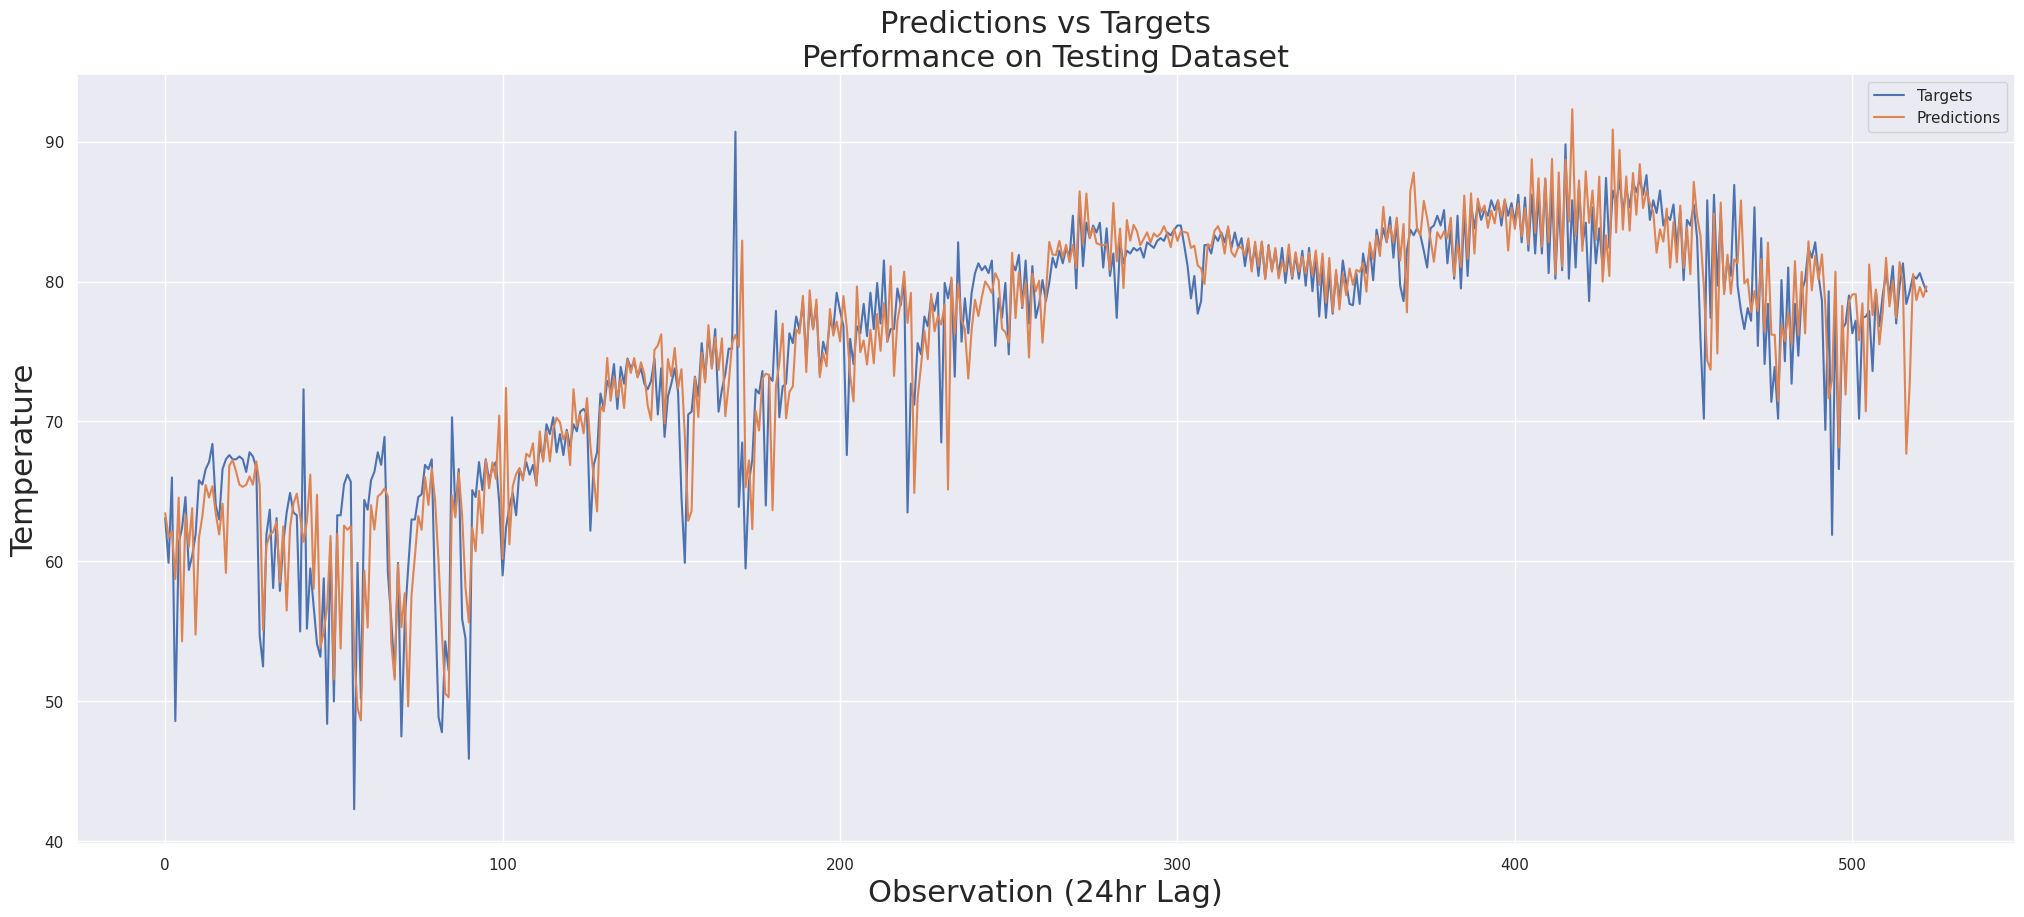

In [106]:
model_plot(predictions, testing_labels, 'Performance on Testing Dataset')